## Here I simulate a simple EIT model in ladder configuration

The system considered is the following:

<img src="three_level_ladder.png" alt="levels" class="bg-primary mb-1" width="300px">


The Hamiltonian is defined as the noninteracting atom-light Hamiltonian plus the interaction one.

$$ H = H_0 + H_1 $$

The nude states in the manifold $(N_p, N_c)$ are:

- $ \ket{1, N_p, N_c} $ with energy $E_1 = 0$
- $ \ket{2, N_p-1, N_c+1} $ with energy $E_2 = -\hbar\Delta_2$
- $ \ket{3, N_p-1, N_c} $ with energy $E_3 = -\hbar\Delta_3$

The noninteracting Hamiltonian is:
$$ H_0 = E_1 \ket{1}\bra{1} + E_2 \ket{2}\bra{2} + E_3 \ket{3}\bra{3} = 
\begin{pmatrix}
    0 & 0 & 0 \\
    0 & -\hbar\Delta_2 & 0 \\
    0 & 0 & -\hbar\Delta_3 \\
\end{pmatrix}
$$

The interacting Hamiltonian is:

$$ H_1 = \hbar\frac{\Omega_p}{2} \ket{1}\bra{3} +\hbar\frac{\Omega_c}{2} \ket{2}\bra{3} + H.c. = 
\hbar\begin{pmatrix}
    0 & 0 & \frac{\Omega_p}{2} \\
    0 & 0 & \frac{\Omega_c}{2} \\
    \frac{\Omega_p}{2} & \frac{\Omega_c}{2} & 0 \\
\end{pmatrix}
$$

So

$$
H = \hbar\begin{pmatrix}
    0 & 0 & \frac{\Omega_p}{2} \\
    0 & -\Delta_2 & \frac{\Omega_c}{2} \\
    \frac{\Omega_p}{2} & \frac{\Omega_c}{2} & -\Delta_3 \\
\end{pmatrix}
$$

I will simulate it with the master equation

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import hbar
from sympy import Matrix
from scipy.integrate import solve_ivp
from arc.alkali_atom_functions import AlkaliAtom
import arc
from IPython.display import clear_output
import qutip as qtp

In [251]:
Om_p = 5
Om_c = 0.5
Delta_3 = -2.2
Delta_2 = 0

steps = 10000
time = 20000
times = np.linspace(0, time, steps)

def H():
    return np.array([
    [ 0     ,   Om_p/2,        0],
    [ Om_p/2, -Delta_2,   Om_c/2],
    [ 0     ,   Om_c/2, -Delta_3],
])

psi0 = np.zeros([3,3])
psi0[0,0] = 1

# jump operators
Gamma_31 = 0.001
Gamma_21 = 1

S_minus_31 = qtp.Qobj(Gamma_31**(1/2)*(np.array([[0,0,1],
                                                 [0,0,0],
                                                 [0,0,0]])))
S_minus_21 = qtp.Qobj(Gamma_21**(1/2)*(np.array([[0,1,0],
                                                 [0,0,0],
                                                 [0,0,0]])))

Jump_ops = [S_minus_31, S_minus_21]

In [252]:
result = qtp.mesolve(qtp.Qobj(H()), qtp.Qobj(psi0), times, c_ops = Jump_ops)

In [253]:
def projector(a,b):
    projector_ = np.zeros([len(H()), len(H())])
    projector_[a,b] = 1
    return projector_

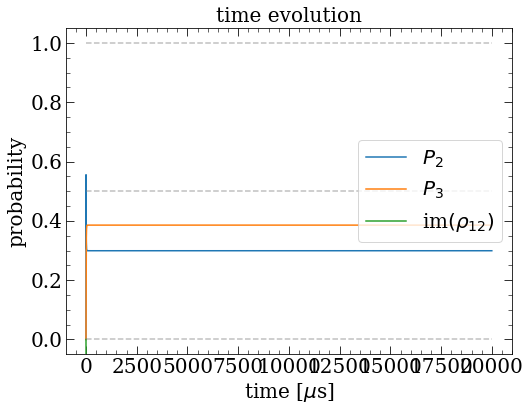

In [254]:
evo = [np.array(result.states[i]) for i in range(steps)]
p_trace_res = {}
labels = [r"$P_1$",r"$P_2$",r"$P_3$"]

out_diag = r"im$(\rho_{12})$"

for l, label in enumerate(labels):
    p_trace_res[label] = [np.trace(np.dot(evo[i], projector(l,l))) for i in range(steps)]

p_trace_res[out_diag] = [np.imag(np.trace(np.dot(evo[i], projector(0,1)))) for i in range(steps)]

plt.figure(figsize=(8,6))

for i, label in enumerate(labels):
    if i != 0:
        plt.plot(times, p_trace_res[label], label=label)
plt.plot(times, p_trace_res[out_diag], label=out_diag)

plt.plot([0,times[-1]],[1,1],"--", alpha=0.5, color="gray")
plt.plot([0,times[-1]],[0,0],"--", alpha=0.5, color="gray")
plt.plot([0,times[-1]],[1/2,1/2],"--", alpha=0.5, color="gray")
plt.ylim([-0.05,1.05])
plt.title("time evolution", fontsize=20)
plt.legend(fontsize=20, loc=5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("time [$\mu$s]", fontsize=20)
plt.ylabel("probability", fontsize=20)

plt.show()

In [255]:
N_points = 100
deltas = np.linspace(-10,10,N_points)
results = []
for i, Delta_3 in enumerate(deltas):
    clear_output(wait=True)
    print("status: %.1f %%"%((i+1)/N_points*100))
    Delta_2 = 0.5
    result = qtp.mesolve(qtp.Qobj(H()), qtp.Qobj(psi0), times, c_ops = Jump_ops)
    results.append(result.states[-1])

status: 100.0 %


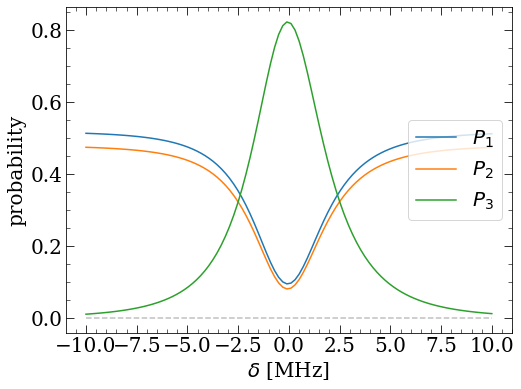

In [256]:
populations = {}
for l, label in enumerate(labels):
    populations[label] = [np.trace(np.dot(results[i],projector(l,l))) for i in range(N_points)]

out_diag = r"im$(\rho_{12})$"

populations[out_diag] = [np.imag(np.trace(np.dot(results[i],projector(0,1)))) for i in range(N_points)]

plt.figure(figsize=(8,6))
for l, label in enumerate(labels):
    
    plt.plot(deltas, populations[label], label = labels[l])

#plt.plot(deltas, populations[out_diag], label = out_diag)

plt.xlabel("$\delta$ [MHz]", fontsize=20)
plt.ylabel("probability", fontsize=20)
plt.legend(fontsize=20, loc=5)
#plt.plot([deltas[0],deltas[-1]],[1,1],"--", alpha=0.5, color="gray")
#plt.plot([deltas[0],deltas[-1]],[0.5,0.5],"--", alpha=0.5, color="gray")
plt.plot([deltas[0],deltas[-1]],[0,0],"--", alpha=0.5, color="gray")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()